✅ Combined multimodal data: (2024, 2167)


/Users/adityashah/miniconda3/envs/atom/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1: Loss = 2.2317
Epoch 2: Loss = 2.1544
Epoch 3: Loss = 2.1822
Epoch 4: Loss = 2.1570
Epoch 5: Loss = 2.1526
Epoch 6: Loss = 2.1353
Epoch 7: Loss = 2.1160
Epoch 8: Loss = 2.1198
Epoch 9: Loss = 2.1011
Epoch 10: Loss = 2.0556
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         6
     disgust       0.00      0.00      0.00        78
        fear       0.00      0.00      0.00        31
   happiness       0.45      0.66      0.53       136
     neutral       0.34      0.87      0.49        63
     sadness       0.14      0.07      0.09        85
    surprise       0.00      0.00      0.00         4
     unknown       0.00      0.00      0.00         2

    accuracy                           0.37       405
   macro avg       0.12      0.20      0.14       405
weighted avg       0.23      0.37      0.28       405



/Users/adityashah/miniconda3/envs/atom/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adityashah/miniconda3/envs/atom/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adityashah/miniconda3/envs/atom/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

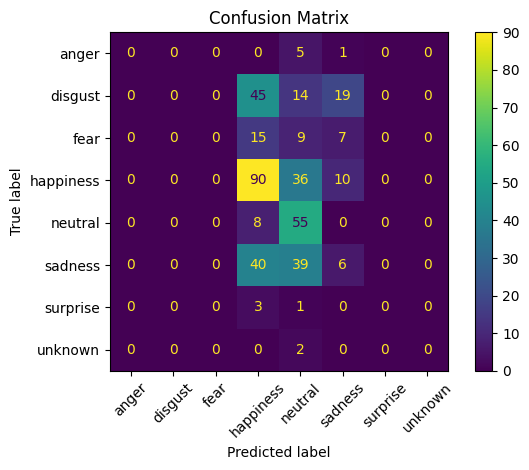

In [14]:
# --- Multimodal Data Loading and Merging ---
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

DATA_DIR = './data/preprocessed_data'

participants = [f"P{i}" for i in range(1, 17)]

# --- Function to Load and Merge Features ---
def load_features(pid):
    try:
        eeg_path = os.path.join(DATA_DIR, f"{pid}_eeg_features.csv")
        audio_path = os.path.join(DATA_DIR, f"{pid}_audio_features.csv")
        video_path = os.path.join(DATA_DIR, f"{pid}_video_features.csv")

        eeg_df = pd.read_csv(eeg_path)
        audio_df = pd.read_csv(audio_path)
        video_df = pd.read_csv(video_path)

        # Fix data type mismatch
        for df in [eeg_df, audio_df, video_df]:
            if df['segment_start'].dtype == 'object':
                try:
                    df['segment_start'] = pd.to_datetime(df['segment_start'], errors='raise')
                    df['segment_start'] = ((df['segment_start'] - df['segment_start'].min()).dt.total_seconds()).astype(int)
                except Exception:
                    df['segment_start'] = df['segment_start'].astype(int)
            else:
                df['segment_start'] = df['segment_start'].astype(int)
            df['participant'] = df['participant'].astype(str)

        merged = pd.merge(eeg_df, audio_df, on=['participant', 'segment_start'])
        merged = pd.merge(merged, video_df, on=['participant', 'segment_start'])

        return merged
    except Exception as e:
        print(f"⚠️ Skipping {pid}: {e}")
        return None

all_data = [load_features(p) for p in participants]
all_data = [df for df in all_data if df is not None]
df = pd.concat(all_data, ignore_index=True)
print(f"✅ Combined multimodal data: {df.shape}")

# --- Encode Labels ---
le = LabelEncoder()
df['label'] = le.fit_transform(df['emotion'])
X = df.drop(columns=['emotion', 'valence', 'arousal', 'participant', 'segment_start', 'label'])
y = df['label']

# Drop non-numeric columns from features if any
X = X.select_dtypes(include=[np.number])

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, stratify=y, random_state=42)

# --- Class Weights ---
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# --- PyTorch Dataset and Dataloader ---
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = EmotionDataset(X_train, y_train)
test_ds = EmotionDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

# --- Transformer-Inspired Model ---
class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # [B, D]
        x = x.unsqueeze(1)  # [B, 1, D]
        x = self.transformer(x)  # [B, 1, D]
        x = self.dropout(x.squeeze(1))  # [B, D]
        return self.out(x)

model = SimpleTransformer(input_dim=X.shape[1], hidden_dim=128, num_classes=len(le.classes_))
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Training Loop ---
def train_model(model, loader):
    model.train()
    for epoch in range(10):
        total_loss = 0
        for xb, yb in loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss/len(loader):.4f}")

train_model(model, train_loader)

# --- Evaluation ---
def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

labels, preds, probs = evaluate(model, test_loader)
print(classification_report(labels, preds, target_names=le.classes_))

# --- Confusion Matrix ---
ConfusionMatrixDisplay.from_predictions(labels, preds, display_labels=le.classes_, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
X.head()

Delta_TP9_mean  Delta_TP9_std  Delta_TP9_min  Delta_TP9_max  \
0        0.677316       0.024091       0.634221       0.688090   
1        0.688090       0.000000       0.688090       0.688090   
2        0.688090       0.000000       0.688090       0.688090   
3        1.104775       0.287984       0.900260       1.506523   
4        0.819551       0.040210       0.790187       0.888059   

   Delta_AF7_mean  Delta_AF7_std  Delta_AF7_min  Delta_AF7_max  \
0             0.0            0.0            0.0            0.0   
1             0.0            0.0            0.0            0.0   
2             0.0            0.0            0.0            0.0   
3             0.0            0.0            0.0            0.0   
4             0.0            0.0            0.0            0.0   

   Delta_AF8_mean  Delta_AF8_std  Delta_AF8_min  Delta_AF8_max  \
0             0.0            0.0            0.0            0.0   
1             0.0            0.0            0.0            0.0   
2             0.0            0.0            0.0            0.0   
3             0.0            0.0            0.0            0.0   
4             0.0            0.0            0.0            0.0   

   Delta_TP10_mean  Delta_TP10_std  Delta_TP10_min  Delta_TP10_max  \
0         0.997298        0.000000        0.997298        0.997298   
1         0.969816        0.082550        0.823571        1.025300   
2         0.939602        0.211791        0.794469        1.260850   
3         0.911660        0.174562        0.639474        1.113641   
4         0.540061        0.173761        0.348776        0.706829   

   Theta_TP9_mean  Theta_TP9_std  Theta_TP9_min  Theta_TP9_max  \
0        0.461587   4.494659e-02       0.381184       0.481687   
1        0.481687   6.206335e-17       0.481687       0.481687   
2        0.481687   6.206335e-17       0.481687       0.481687   
3        1.186514   2.815871e-01       0.980896       1.500982   
4        0.652215   2.207308e-01       0.356358       0.829236   

   Theta_AF7_mean  Theta_AF7_std  Theta_AF7_min  Theta_AF7_max  \
0             0.0            0.0            0.0            0.0   
1             0.0            0.0            0.0            0.0   
2             0.0            0.0            0.0            0.0   
3             0.0            0.0            0.0            0.0   
4             0.0            0.0            0.0            0.0   

   Theta_AF8_mean  Theta_AF8_std  Theta_AF8_min  Theta_AF8_max  \
0             0.0            0.0            0.0            0.0   
1             0.0            0.0            0.0            0.0   
2             0.0            0.0            0.0            0.0   
3             0.0            0.0            0.0            0.0   
4             0.0            0.0            0.0            0.0   

   Theta_TP10_mean  Theta_TP10_std  Theta_TP10_min  Theta_TP10_max  \
0         0.580849        0.000000        0.580849        0.580849   
1         0.721123        0.191432        0.580849        0.997021   
2         0.615841        0.056640        0.574513        0.681177   
3         0.569272        0.258230        0.292988        0.867803   
4         0.248525        0.082472        0.187074        0.366179   

   Alpha_TP9_mean  Alpha_TP9_std  Alpha_TP9_min  Alpha_TP9_max  \
0        0.165219   1.058820e-01       0.117867       0.354626   
1        0.117867   1.551584e-17       0.117867       0.117867   
2        0.117867   1.551584e-17       0.117867       0.117867   
3        0.758889   4.832734e-02       0.736276       0.845282   
4        0.891107   7.634266e-02       0.838941       1.022345   

   Alpha_AF7_mean  Alpha_AF7_std  Alpha_AF7_min  Alpha_AF7_max  \
0             0.0            0.0            0.0            0.0   
1             0.0            0.0            0.0            0.0   
2             0.0            0.0            0.0            0.0   
3             0.0            0.0            0.0            0.0   
4             0.0            0.0            0.0     

In [8]:
print(X.columns)

Index(['Delta_TP9_mean', 'Delta_TP9_std', 'Delta_TP9_min', 'Delta_TP9_max',
       'Delta_AF7_mean', 'Delta_AF7_std', 'Delta_AF7_min', 'Delta_AF7_max',
       'Delta_AF8_mean', 'Delta_AF8_std',
       ...
       'resnet_2038', 'resnet_2039', 'resnet_2040', 'resnet_2041',
       'resnet_2042', 'resnet_2043', 'resnet_2044', 'resnet_2045',
       'resnet_2046', 'resnet_2047'],
      dtype='object', length=2162)


In [11]:
X.select_dtypes(include=['object']).head()

,emotion_x,emotion_y
0,neutral,neutral
1,neutral,neutral
2,neutral,neutral
3,neutral,neutral
4,happiness,neutral
